In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [48]:
def non_max_suppresion(boxes, overlapThreshold):
    """
    Perform non max suppresion
    Args:
        boxes (List): List of tuples (x, y, w, h) where (x, y) is the top left corner of the bounding box.
        overlapThreshold (float): Threshold for the overlap.
    Returns:
        suppressed (List): List of tuples (x, y, w, h) after non max suppresion.
    """
    if len(boxes) == 0:
        return []

    boxes = np.array(boxes)
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 0] + boxes[:, 2]
    y2 = boxes[:, 1] + boxes[:, 3]

    area = boxes[:, 2] * boxes[:, 3]
    idxs = np.argsort(y2)

    suppressed = []

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        suppressed.append(boxes[i])

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThreshold)[0])))

    return suppressed

def find_objects(img, template_paths, objects, scales, threshold=0.5, mask_value=230, output_path=None):
    """
    Find objects in an image using template matching.
    Args:
        img (np.ndarray): The image to match the templates to.
        template_paths (list): List of paths to the templates.
        objects (list): List of labels for the objects.
        scales (np.ndarray): Array of scales to resize the templates.
        threshold (float): Threshold for the match.
        mask_value (int): Mask values bigger than this to 0.
        output_path (str): Path to save the output image (None to not save).        
    """
    
    boxes = []
    copy = img.copy()

    for template_path, label in zip(template_paths, objects):
        print(f'Searching for {label}...')
        template = cv.imread(template_path, 0)

        template_mask = np.where(template < mask_value, 1, 0).astype(np.uint8)

        best_match = None
        best_val = -1

        for scale in scales:
            resized_template = cv.resize(template, (0, 0), fx=scale, fy=scale)
            resized_mask = cv.resize(template_mask, (0, 0), fx=scale, fy=scale)

            w, h = resized_template.shape[::-1]
            result = cv.matchTemplate(img, resized_template, cv.TM_CCORR_NORMED, mask=resized_mask)
            plt.imshow(result, cmap='gray')

            _, max_val, _, max_loc = cv.minMaxLoc(result)

            if max_val > best_val:
                best_val = max_val
                best_match = (*max_loc, w, h)

        if best_match and best_val >= threshold:
            boxes.append(best_match)

    for box in boxes:
        x, y, w, h = box
        cv.rectangle(copy, (x, y), (x + w, y + h), (0, 0, 255), thickness=4)
        cv.putText(copy, label, (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, fontScale=3, color=(0, 0, 0), thickness=5)
        
    if output_path:
        cv.imwrite(output_path, copy)
        
    plt.imshow(copy, cmap='gray')
    plt.show()

def count_objects(img, template_paths, objects, scales, threshold=0.5,  output_path=None, suppression_value=0.05):
    """
    Count objects in an image using template matching.
    Args:
        img (np.ndarray): The image to match the templates to.
        template_paths (list): List of paths to the templates.
        objects (list): List of labels for the objects.
        scales (np.ndarray): Array of scales to resize the templates.
        threshold (float): Threshold for the match.
        output_path (str): Path to save the output image (None to not save).
        suppression_value (float): Threshold for the overlap.
    """
    copy = img.copy()

    boxes = []
    
    for template_path, label in zip(template_paths, objects):
        print(f'Searching for {label}...')
        template = cv.imread(template_path, 0)

        for scale in scales:
            resized_template = cv.resize(template, (0, 0), fx=scale, fy=scale)
            w, h = resized_template.shape[::-1]

            result = cv.matchTemplate(img, resized_template, cv.TM_CCOEFF_NORMED)

            # Get matches with a value above the threshold
            loc = np.where(result >= threshold)
            for top_pos in zip(*loc[::-1]):
                boxes.append((*top_pos, w, h))

    boxes = non_max_suppresion(boxes, suppression_value)

    for box in boxes:
        x, y, w, h = box
        cv.rectangle(copy, (x, y), (x + w, y + h), (0, 0, 255), thickness=4)
        cv.putText(copy, label, (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0, 0, 0), thickness=5)

    plt.figure(figsize=(10, 10))
    plt.imshow(copy, cmap='gray')
    plt.title(f'Count: {len(boxes)}')
    if output_path:
        plt.savefig(output_path)

    plt.show()

# Task 1: Find objects

## Example 1

In [ ]:
img_path_1 = '../Finding/1/1_target.jpg'
objects_1 = ['ball', 'bear', 'boat', 'bowtie', 'cake', 'car', 'duck', 'grape', 'horse', 'icecream', 'melon', 'rabbit', 'strawberry', 'train']
template_paths_1 = [f'../data/finding/1/1_{object}.jpg' for object in objects_1]

### 1.1.1 Visualize target + templates

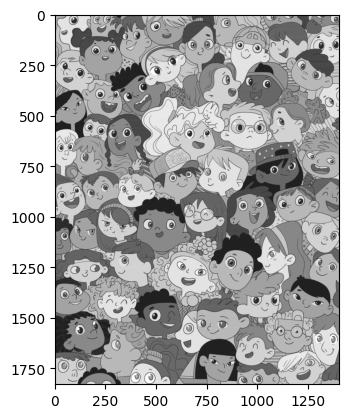

In [13]:
img = cv.imread(img_path_1, 0)
plt.imshow(img, cmap='gray')

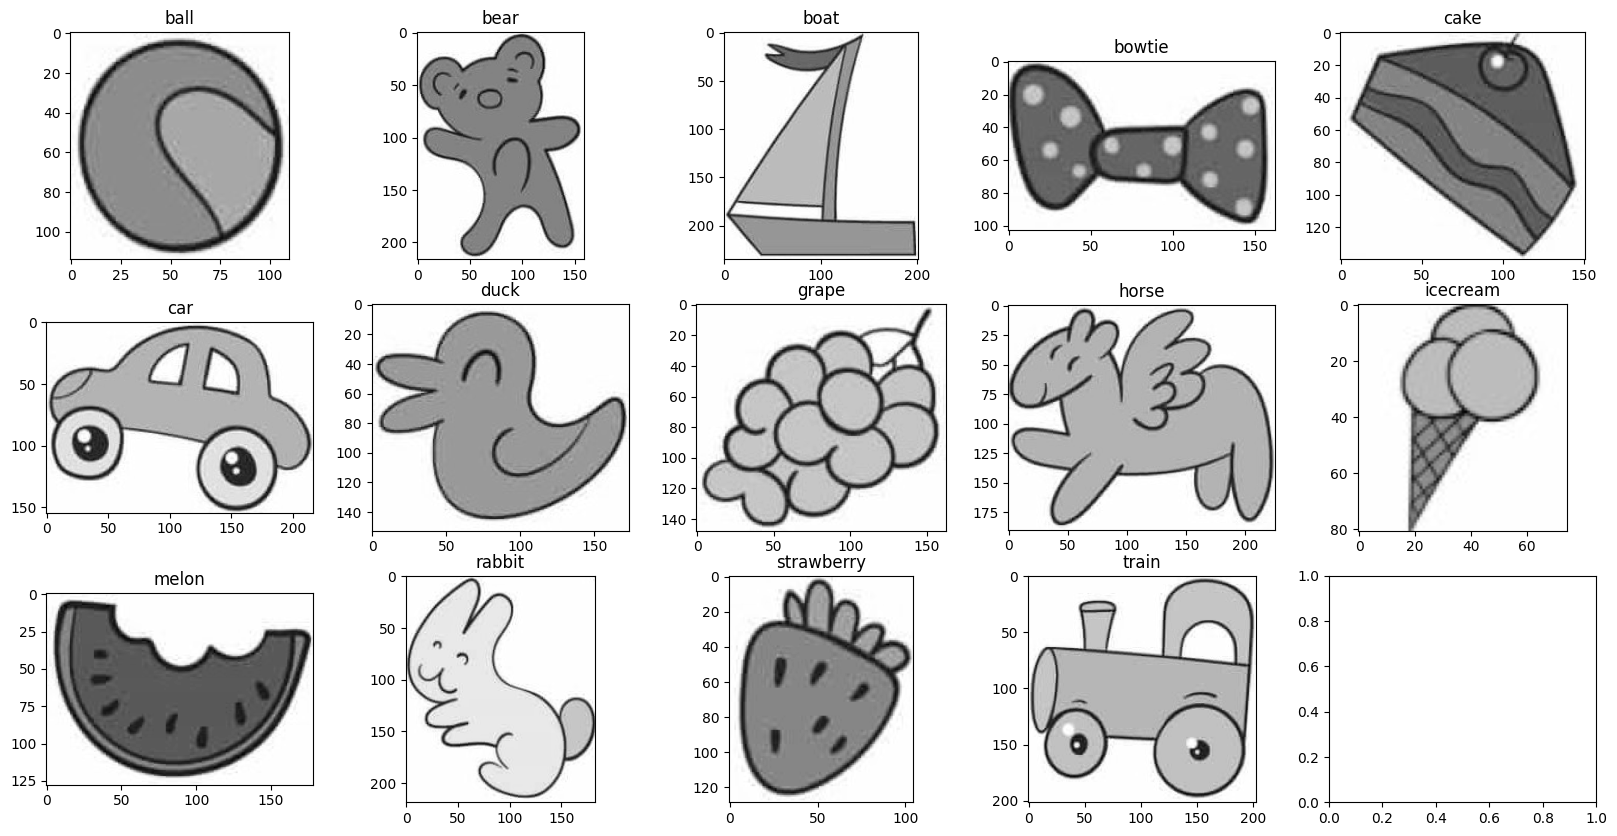

In [19]:
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
axes = axes.flatten()

for i, template_path in enumerate(template_paths_1):
    template = cv.imread(template_path, 0)
    axes[i].imshow(template, cmap='gray')
    axes[i].set_title(objects_1[i])
plt.show()

### 1.1.2 Match templates

Searching for ball...
Searching for bear...
Searching for boat...
Searching for bowtie...
Searching for cake...
Searching for car...
Searching for duck...
Searching for grape...
Searching for horse...
Searching for icecream...
Searching for melon...
Searching for rabbit...
Searching for strawberry...
Searching for train...


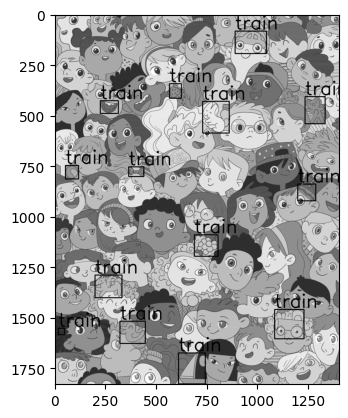

In [25]:
threshold = 0.5
scales = np.linspace(0.4, 1.0, 20)

find_objects(img=img, template_paths=template_paths_1, objects=objects_1, scales=scales, threshold=threshold)

## Example 2

In [30]:
img_path_2 = '../Finding/2/2_target.jpg'

objects_2 = ['ball', 'baloon', 'bone', 'bowtie', 'butterfly', 'cheese', 'chicken', 'cloud', 'icecream', 'icecreamcone', 'sausage', 'strawberry']
template_paths_2 = [f'../Finding/2/2_{object}.jpg' for object in objects_2]

### 1.2.1 Visualize target + templates

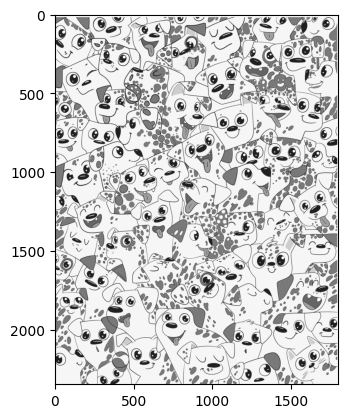

In [31]:
img = cv.imread(img_path_2, 0)
plt.imshow(img, cmap='gray')

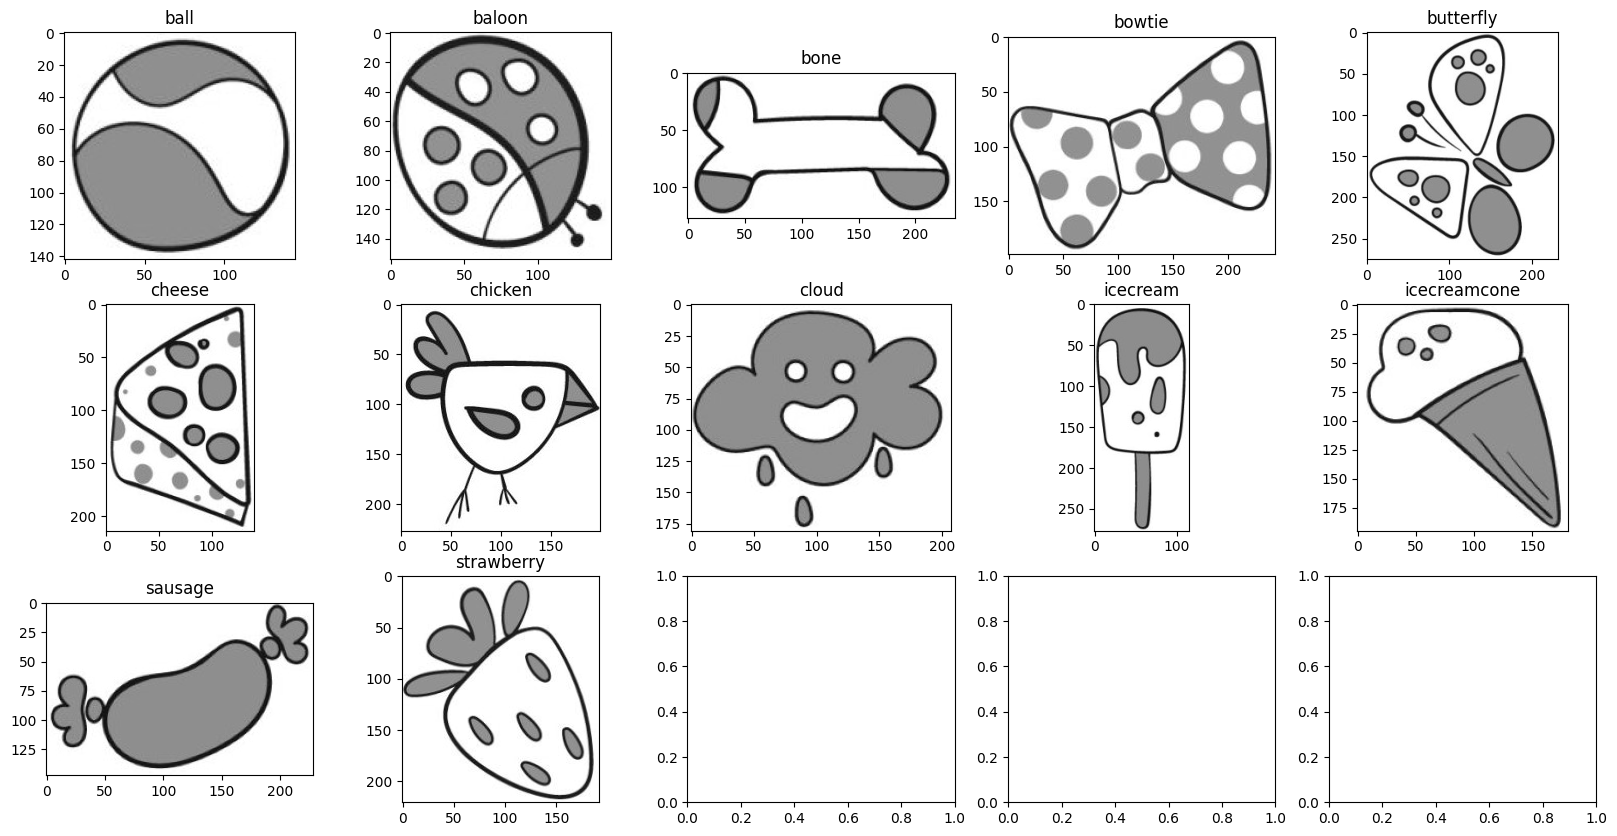

In [32]:
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
axes = axes.flatten()

for i, template_path in enumerate(template_paths_2):
    template = cv.imread(template_path, 0)
    axes[i].imshow(template, cmap='gray')
    axes[i].set_title(objects_2[i])
plt.show()

### 1.2.2 Match templates

Searching for ball...
Searching for baloon...
Searching for bone...
Searching for bowtie...
Searching for butterfly...
Searching for cheese...
Searching for chicken...
Searching for cloud...
Searching for icecream...
Searching for icecreamcone...
Searching for sausage...
Searching for strawberry...


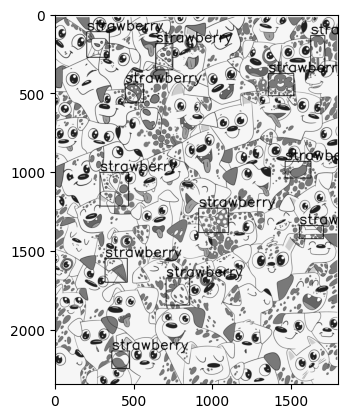

In [33]:
threshold = 0.5
scales = np.linspace(0.4, 1.0, 20)

find_objects(img=img, template_paths=template_paths_2, objects=objects_2, scales=scales, threshold=threshold)

# Task 2: Count objects

###  Example 1

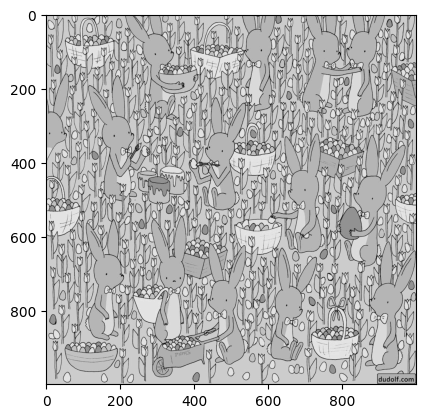

In [81]:
img = cv.imread('../Counting/rabbit/rabbit.jpeg', 0)
template_paths = ['../Counting/rabbit/rabbit_template.jpeg', '../Counting/rabbit/rabbit_template3.jpeg', '../Counting/rabbit/rabbit_template4.jpeg']
objects = ['rabbit', 'rabbit', 'rabbit']

img = cv.imread('../Counting/rabbit/rabbit.jpeg', 0)
plt.imshow(img, cmap='gray')

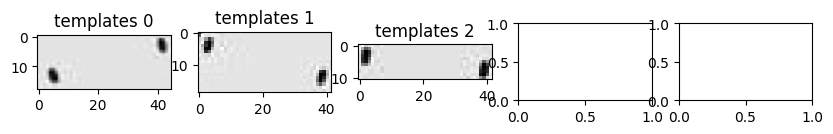

In [82]:
fig, axes = plt.subplots(1, 5, figsize=(10, 1))
axes = axes.flatten()

for i, template_path in enumerate(template_paths):
    template = cv.imread(template_path, 0)
    axes[i].imshow(template, cmap='gray')
    axes[i].set_title(f'templates {i}')
plt.show()

Searching for rabbit...
Searching for rabbit...
Searching for rabbit...


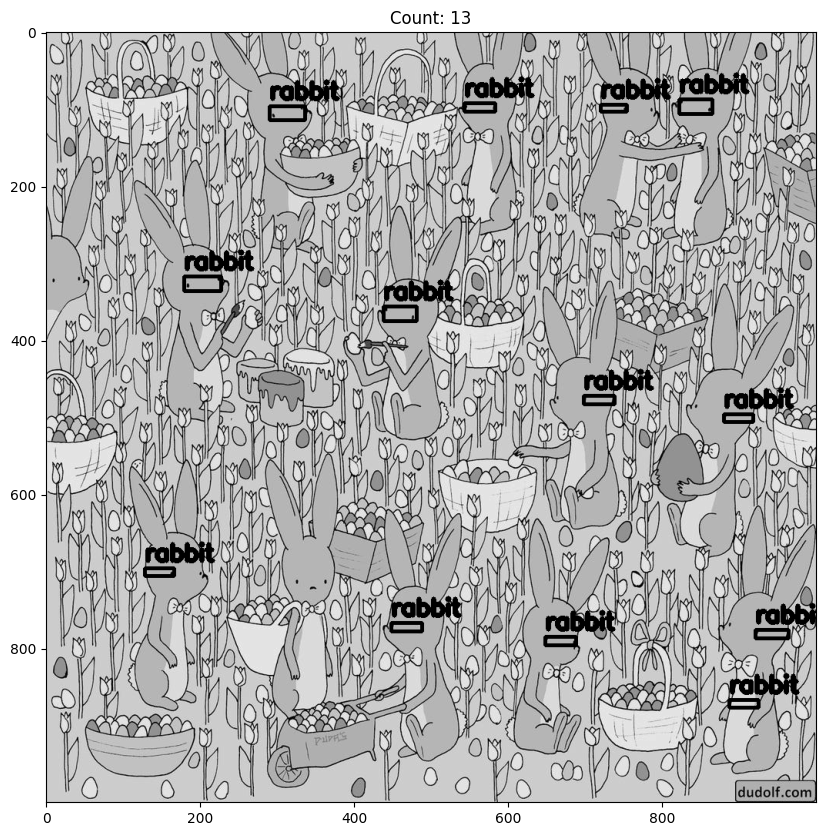

In [83]:
threshold = 0.69
scales = np.linspace(0.8, 1.4, 12)

count_objects(img=img, template_paths=template_paths, objects=objects, scales=scales, threshold=threshold, output_path="res4", suppression_value=0.05)

### Example 2

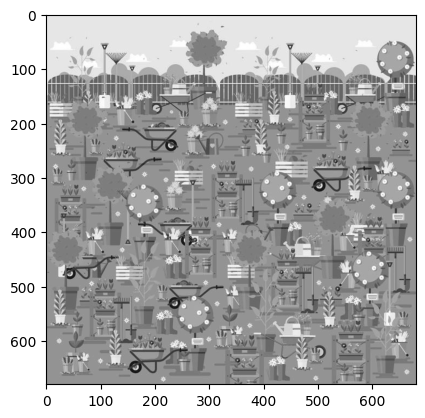

In [78]:
img = cv.imread('../Counting/pair_boot/pair_boot.jpg', 0)
template_paths = ['../Counting/pair_boot/pair_boot_template2.jpg']
objects = ['?']

plt.imshow(img, cmap='gray')

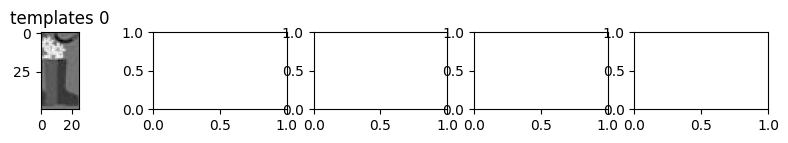

In [79]:
fig, axes = plt.subplots(1, 5, figsize=(10, 1))
axes = axes.flatten()

for i, template_path in enumerate(template_paths):
    template = cv.imread(template_path, 0)
    axes[i].imshow(template, cmap='gray')
    axes[i].set_title(f'templates {i}')
plt.show()

Searching for ?...


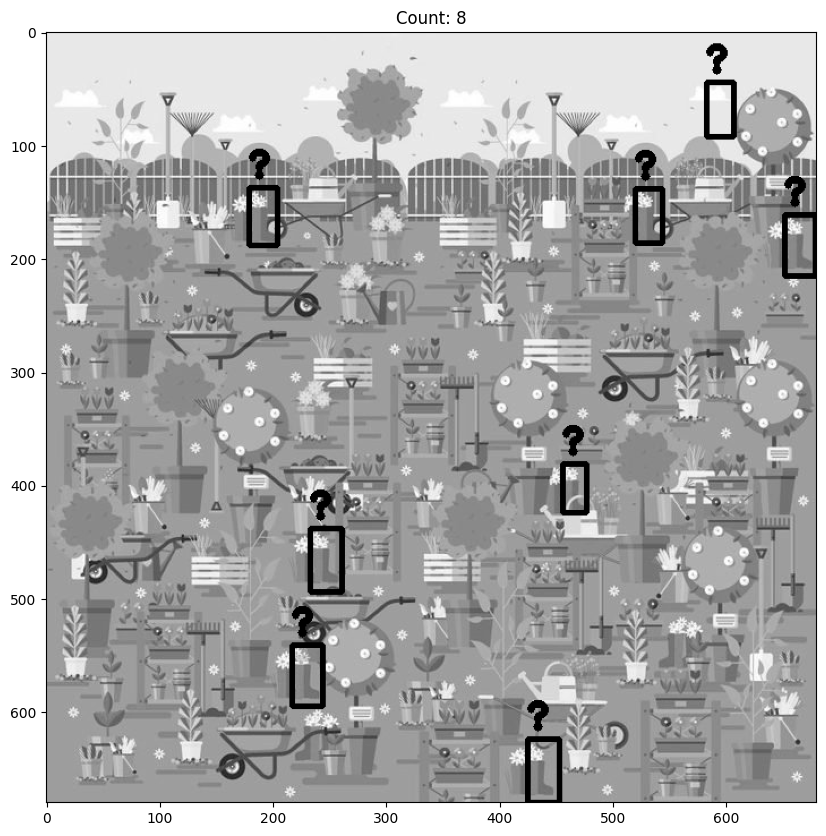

In [80]:
threshold = 0.7
scales = np.linspace(0.8, 1.4, 12)

count_objects(img=img, template_paths=template_paths, objects=objects, scales=scales, threshold=threshold, output_path="res4", suppression_value=0.05)